In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

from sr_model.models.models import AnalyticSR
from datasets import inputs

/Users/chingfang/Code/sr-project/datasets/inputs.py:12: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")


In [37]:
dataset = inputs.Sim1DFeederAndCache(
    steps_in_phases=[0,2000,0],
    left_right_stay_prob=[5,1,1]
    )

# Sanity Check Plots

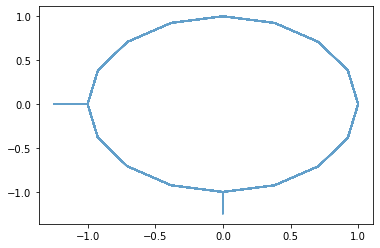

In [38]:
plt.figure();
plt.plot(dataset.xs, dataset.ys, alpha=0.7)
plt.show()

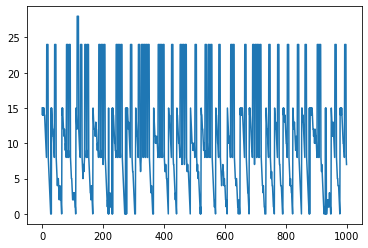

In [39]:
plt.figure();
plt.plot(dataset.state_inputs[:1000])
plt.show()

# Run through model

In [40]:
def get_M(T, gamma):
    return np.linalg.pinv(np.eye(T.shape[0]) - gamma*T)
    
def normalize(T):
    row_sums = np.sum(T, axis=0)
    unvisited_states = (row_sums == 0)
    T = T/row_sums[:, np.newaxis]
    T[unvisited_states] = 0
    return T

In [46]:
outputs = []
gamma = 0.9
est_T = np.zeros((dataset.num_states, dataset.num_states))
prev_state = None
for step in np.arange(dataset.num_steps):
    curr_state = dataset.state_inputs[step]
    outputs.append(get_M(est_T, gamma)[:,curr_state])
    est_T[prev_state, curr_state] += 1
    est_T = normalize(est_T)
outputs = np.array(outputs)

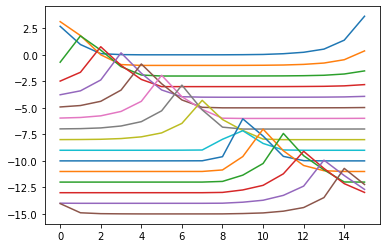

In [50]:
all_ffs = []
mod_state_inputs = np.mod(dataset.state_inputs, dataset.num_spatial_states)
neurs_to_plot = np.concatenate((
    np.arange(dataset.num_spatial_states),
    #[dataset.feeder_state + dataset.num_spatial_states],
    #[dataset.cache_state + dataset.num_spatial_states]
    ))
plt.figure()
plt_idx = 0
plt_idx_interval = -1.
for neur in neurs_to_plot:
    activity = outputs[:, neur]
    ff = np.zeros(dataset.num_spatial_states)
    for state in np.arange(dataset.num_spatial_states):
        ff[state] = np.mean(
            activity[mod_state_inputs==state]
            )
    plt.plot(ff + plt_idx)
    plt_idx += plt_idx_interval
    all_ffs.append(ff)
all_ffs = np.array(all_ffs)
plt.show()

In [48]:
neurs_to_analyze = np.concatenate((
    np.arange(dataset.num_spatial_states),
    #[dataset.feeder_state + dataset.num_spatial_states],
    #[dataset.cache_state + dataset.num_spatial_states]
    ))
all_ffs = all_ffs[neurs_to_analyze]

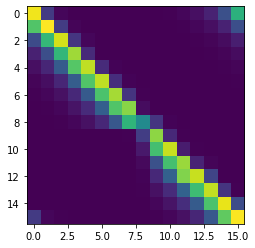

In [44]:
plt.figure()
plt.imshow(all_ffs[np.argsort(np.argmax(all_ffs,axis=1))])
plt.show()

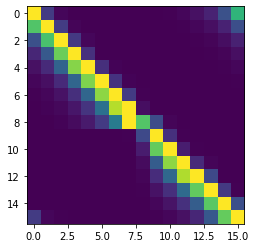

In [45]:
plt.figure()
ffs_to_plot = all_ffs[np.argsort(np.argmax(all_ffs,axis=1))]
plt.imshow(ffs_to_plot/np.max(ffs_to_plot,axis=1)[:,np.newaxis])
plt.show()